In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import pickle
import tqdm
import numpy
from scipy import interpolate
import healpy
import gaia_tools.load, gaia_tools.select
from galpy.util import bovy_plot, bovy_coords, save_pickles, multi
import mwdust
import effsel
from effsel import main_sequence_cut_r, giant_sequence_cut
%pylab inline
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import NullFormatter, FuncFormatter, LogFormatter
from matplotlib.colors import LogNorm
from matplotlib import gridspec
save_figures= False
numpy.random.seed(1)
nside= 2**5

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# The completeness of *TGAS* for different stellar types

In this notebook, we derive the completeness of *TGAS* for different stellar types as a function of distance and, more generally, as a function of position in the Galaxy. We use the underlying *TGAS* selection function for this and use *TGAS*' color-magnitude distributions for different stellar types to convert the *TGAS* selection function to an effective selection function and effective volume.

For main-sequence stars (dwarfs), we adopt the relations from Pecaut & Mamajek (2013) (downloaded from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt) to define different stellar types. We first load these relations and the *TGAS* data:

In [3]:
sp= effsel.load_spectral_types()
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
dm= -5.*numpy.log10(tgas['parallax'])+10.
mj= twomass['j_mag']-dm

and then plot the *TGAS* color--absolute-magnitude diagram:

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"



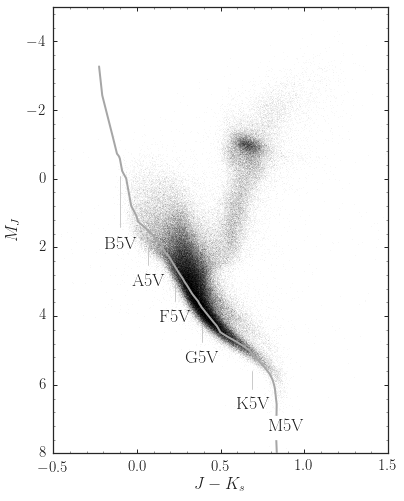

In [4]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,8)
# Select stars with 'good' parallaxes (somewhat circularly depending on their absolute magnitude...)
def good_relplx(mj):
    out= numpy.empty_like(mj)
    out[mj > 5.]= 20.
    out[mj < 0.]= 10.
    out[(mj >= 0)*(mj <= 5.)]= 20.+2.*(mj[(mj >= 0)*(mj <= 5.)]-5.)
    return out
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    (twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.03,zorder=1,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)*(not 'Y' in s)\
                      *(not '.5V' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=3,overplot=True)
ann_sp= ['B5V','A5V','F5V','G5V','K5V','M5V']
for ap in ann_sp:
    sp_indx= sp['SpT'] == ap
    offset= 1.5
    if ap == 'M5V': offset= -2.
    if ap == 'B5V': offset= 2.5
    t= pyplot.text((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx]+offset,
                        r'$\mathrm{%s}$' % ap,size=18.,
                       horizontalalignment='center',verticalalignment='center')
    if ap == 'M5V': t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
    else:
        plot(((sp['JH']+sp['HK'])[sp_indx],(sp['JH']+sp['HK'])[sp_indx]),
         (sp['M_J'][sp_indx]+offset-0.5,sp['M_J'][sp_indx]+0.5),'0.75',lw=0.8)
if False:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','cmd.pdf'),
                bbox_inches='tight')

How does $J-K_s$ map to spectral type?

(0.0, 79.0)

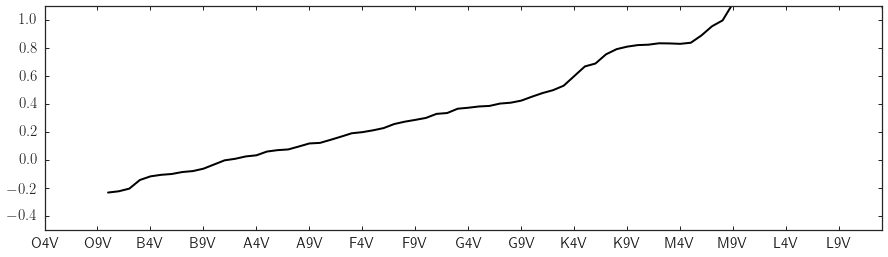

In [5]:
figsize(15,4)
sp_indx= numpy.array([(not '.5V' in s) for s in sp['SpT']],dtype='bool')
plot((sp['JH']+sp['HK'])[sp_indx],'k-',lw=2.)
gca().xaxis.set_ticks(numpy.arange(numpy.sum(sp_indx))[::5])
_= gca().xaxis.set_ticklabels(sp['SpT'][sp_indx][1::5])
ylim(-0.5,1.1)
xlim(0.,79.)

Let's isolate the main-sequence, with a wide cut for star counts and a tight cut for determining the $(J-K_s,M_J)$ relation. The wide cut looks as follows:

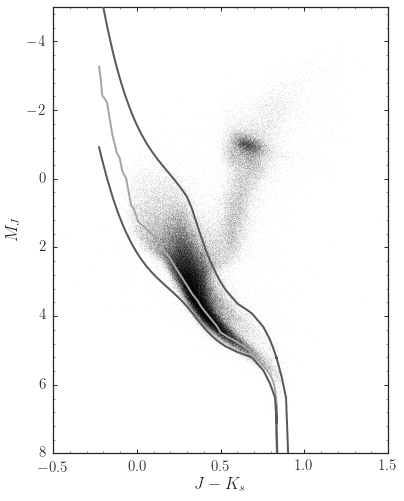

In [6]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,8)
# Select stars with 'good' parallaxes (somewhat circularly depending on their absolute magnitude...)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    (twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.03,zorder=1,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=3,overplot=True)
# Cuts
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx]),
                    color='0.35',lw=2.,zorder=3,overplot=True)
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],low=True),
                    color='0.35',lw=2.,zorder=3,overplot=True)

The tight cut looks like this:

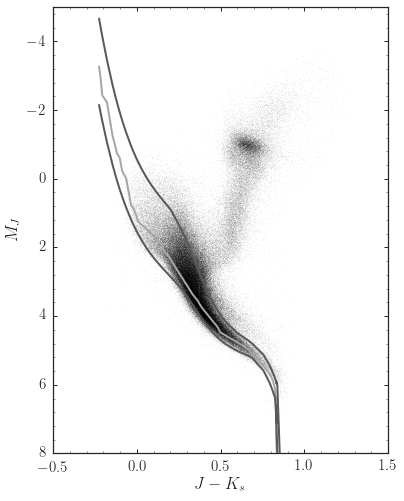

In [7]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,8)
# Select stars with 'good' parallaxes (somewhat circularly depending on their absolute magnitude...)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    (twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.03,zorder=1,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=3,overplot=True)
# Cuts
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],tight=True),
                    color='0.35',lw=2.,zorder=3,overplot=True)
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],low=True,tight=True),
                    color='0.35',lw=2.,zorder=3,overplot=True)

All of this in one plot:

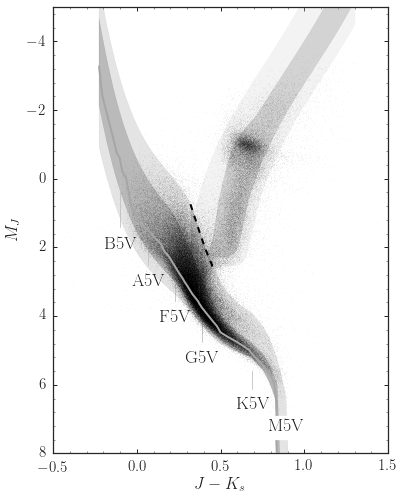

In [8]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,8)
# Select stars with 'good' parallaxes (somewhat circularly depending on their absolute magnitude...)
def good_relplx(mj):
    out= numpy.empty_like(mj)
    out[mj > 5.]= 20.
    out[mj < 0.]= 10.
    out[(mj >= 0)*(mj <= 5.)]= 20.+2.*(mj[(mj >= 0)*(mj <= 5.)]-5.)
    return out
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    (twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.03,zorder=3,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)*(not 'Y' in s)\
                      *(not '.5V' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=4,overplot=True)
# Cuts
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s) for s in sp['SpT']],dtype='bool')
pyplot.fill_between((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx]),
                    main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],low=True),
                    color='0.65',zorder=1,alpha=0.3)
pyplot.fill_between((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],tight=True),
                    main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],tight=True,low=True),
                    color='0.35',zorder=1,alpha=0.3)
jks= numpy.linspace(0.32,1.3,101)
pyplot.fill_between(jks,giant_sequence_cut(jks,tight=False),giant_sequence_cut(jks,tight=False,low=True),
                    color='0.85',zorder=1,alpha=0.3)
pyplot.fill_between(jks,giant_sequence_cut(jks,tight=True),giant_sequence_cut(jks,tight=True,low=True),
                    color='0.55',zorder=1,alpha=0.3)
jks= numpy.linspace(0.32,0.45,101)
plot(jks,giant_sequence_cut(jks,tight=False,low=True),'k--',lw=2.)
ann_sp= ['B5V','A5V','F5V','G5V','K5V','M5V']
for ap in ann_sp:
    sp_indx= sp['SpT'] == ap
    offset= 1.5
    if ap == 'M5V': offset= -2.
    if ap == 'B5V': offset= 2.5
    t= pyplot.text((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx]+offset,
                        r'$\mathrm{%s}$' % ap,size=18.,zorder=10,
                       horizontalalignment='center',verticalalignment='center')
    if ap == 'M5V': t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
    else:
        plot(((sp['JH']+sp['HK'])[sp_indx],(sp['JH']+sp['HK'])[sp_indx]),
         (sp['M_J'][sp_indx]+offset-0.5,sp['M_J'][sp_indx]+0.5),'0.75',lw=0.8)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','cmd_wcuts.pdf'),
                bbox_inches='tight')

## Completeness as a function of distance for different stellar types

Let's now compute the effective selection function as a function of distance for different stellar typess. We first load the effective selection. We'll assume that there is no dust extinction here; otherwise this function depends on the location on the sky.

In [9]:
tsf= gaia_tools.select.tgasSelect()
tesf= gaia_tools.select.tgasEffectiveSelect(tsf,dmap3d=mwdust.Zero())
tesf_ext= gaia_tools.select.tgasEffectiveSelect(tsf,dmap3d=mwdust.Combined15(filter='2MASS J'))

In [10]:
def select_giants(giant_type,jk,mj,tight=False):
    """Returns index into jk,mj of giants of a certain type"""
    if 'subgiant' in giant_type:
        mjlow, mjhigh= 4., 1.
    elif 'lower RGB' in giant_type:
        mjlow, mjhigh= 1., -0.5
    elif 'RC' in giant_type:
        mjlow, mjhigh= -0.5, -1.5
    elif 'upper RGB' in giant_type:
        mjlow, mjhigh= -1.5, -4.
    return (jk > 0.32)*(jk < 1.)\
            *(mj < giant_sequence_cut(jk,tight=tight,low=True))\
            *(mj > giant_sequence_cut(jk,tight=tight))\
            *(mj <= mjlow)*(mj > mjhigh)

In [11]:
dms= numpy.linspace(-2.,15.,1001)
dists= 10.**(0.2*dms-2.)
ra_cen, dec_cen= -100., 40. #Just some location in the good part of the sky
SpTypes= ['A','F','G','K','M']
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
esfs= numpy.empty((len(SpTypes),len(dms)))
for ii,sptype in enumerate(SpTypes):
    # Find this stellar type
    jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
    if sptype == 'M':
        jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
    else:
        jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
    jmin= main_sequence_cut_r(jkmax)
    jmax= main_sequence_cut_r(jkmin)
    good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                    *(mj < main_sequence_cut_r(jk,tight=True,low=True))\
                    *(mj > main_sequence_cut_r(jk,tight=True))
    esfs[ii]= tesf(dists,ra_cen,dec_cen,MJ=mj[good_sampling],JK=jk[good_sampling])

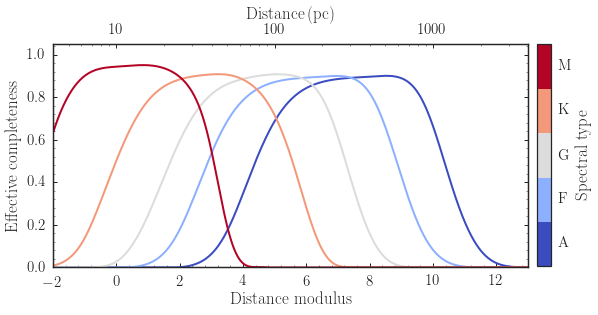

In [12]:
figsize(8,4)
cmap= cm.coolwarm
for ii,sptype in enumerate(SpTypes):
    bovy_plot.bovy_plot(dms,esfs[ii],'-',
                        color=cmap(float(ii)/(len(SpTypes)-1)),
                        lw=2.,overplot=ii>0,
                        xlabel=r'$\mathrm{Distance\ modulus}$',
                        ylabel=r'$\mathrm{Effective\ completeness}$',
                        xrange=[-2.,13.],
                        yrange=[0.,1.05])
# Add distance axis on top
xmin, xmax= pyplot.gca().xaxis.get_view_interval()
ax2= pyplot.twiny()
ax2.set_xscale('log')
ax2.xaxis.set_view_interval(10.**(0.2*xmin+1.),10.**(0.2*xmax+1.),ignore=True)
ax2.set_xlabel('$\mathrm{Distance}\,(\mathrm{pc})$',
               ha='center',x=0.5)
ax2.xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
# Add colorbar
ticknames= [r'$\mathrm{%s}$' % sptype for sptype in SpTypes]
ticks= numpy.arange(len(SpTypes))
fig= pyplot.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.965, 0.13, 0.025, 0.77])
tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
sm = pyplot.cm.ScalarMappable(cmap=tcmap,
                              norm=pyplot.Normalize(vmin=-0.5,vmax=len(SpTypes)-0.5))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,
                   ticks=ticks)
cbar.set_ticklabels(ticknames)
cbar.set_label(r'$\mathrm{Spectral\ type}$')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_ms_distance.pdf'),
                bbox_inches='tight')

Same for giants:

In [13]:
dms= numpy.linspace(-2.,15.,101)
dists= 10.**(0.2*dms-2.)
ra_cen, dec_cen= -100., 40. #Just some location in the good part of the sky
SpTypes= ['subgiants','lower RGB','RC','upper RGB']
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
esfs= numpy.empty((len(SpTypes),len(dms)))
for ii,sptype in enumerate(SpTypes):
    # Find this stellar type
    good_sampling= good_plx_indx*select_giants(sptype,jk,mj,tight=True)
    esfs[ii]= tesf(dists,ra_cen,dec_cen,MJ=mj[good_sampling],JK=jk[good_sampling])

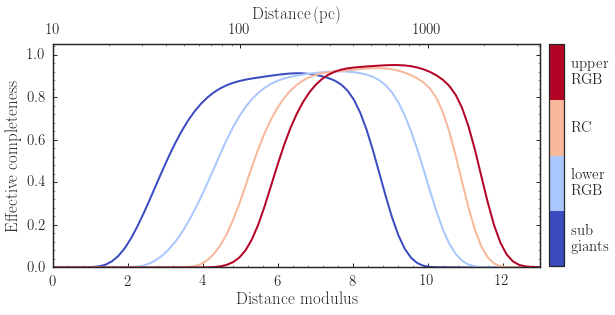

In [14]:
figsize(8.2,4)
cmap= cm.coolwarm
SpTypes= ['subgiants','lower RGB','RC','upper RGB']
for ii,sptype in enumerate(SpTypes):
    bovy_plot.bovy_plot(dms,esfs[ii],'-',
                        color=cmap(float(ii)/(len(SpTypes)-1)),
                        lw=2.,overplot=ii>0,
                        xlabel=r'$\mathrm{Distance\ modulus}$',
                        ylabel=r'$\mathrm{Effective\ completeness}$',
                        xrange=[0.,13.],
                        yrange=[0.,1.05])
# Add distance axis on top
xmin, xmax= pyplot.gca().xaxis.get_view_interval()
ax2= pyplot.twiny()
ax2.set_xscale('log')
ax2.xaxis.set_view_interval(10.**(0.2*xmin+1.),10.**(0.2*xmax+1.),ignore=True)
ax2.set_xlabel('$\mathrm{Distance}\,(\mathrm{pc})$',
               ha='center',x=0.5)
ax2.xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
# Add colorbar
ticknames= [r'$\mathrm{sub}$'+'\n'+r'$\mathrm{giants}$',
            r'$\mathrm{lower}$'+'\n'+r'$\mathrm{RGB}$',
            r'$\mathrm{RC}$',
            r'$\mathrm{upper}$'+'\n'+r'$\mathrm{RGB}$']
ticks= numpy.arange(len(SpTypes))
fig= pyplot.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.965, 0.13, 0.025, 0.77])
tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
sm = pyplot.cm.ScalarMappable(cmap=tcmap,
                              norm=pyplot.Normalize(vmin=-0.5,vmax=len(SpTypes)-0.5))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,
                   ticks=ticks)
cbar.set_ticklabels(ticknames)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_giants_distance.pdf'),
                bbox_inches='tight')

Let's see how extinction affects this effective completeness for F stars:

In [15]:
# Determine the mean extinction to ~400 pc in the extinction map at the nside level
nside= 2**5
nside_max = numpy.amax(tesf_ext._dmap3d._nsides)
medext_hires= numpy.empty(healpy.nside2npix(nside_max),dtype='f8')
dm_indx= 8 # ~400 pc
for tnside in tesf_ext._dmap3d._nsides:
    # Get indices of all pixels at current nside level
    idx = tesf_ext._dmap3d._pix_info['nside'] == tnside
    # Extract extinction of each selected pixel
    pix_val_n = tesf_ext._dmap3d._best_fit[idx,dm_indx]
    # Determine nested index of each selected pixel in upsampled map
    mult_factor = (nside_max/tnside)**2
    pix_idx_n = tesf_ext._dmap3d._pix_info['healpix_index'][idx] * mult_factor    
    # Write the selected pixels into the upsampled map
    for offset in range(mult_factor):
        medext_hires[pix_idx_n+offset] = pix_val_n[:]
# Degrade
med_ext= healpy.ud_grade(medext_hires,nside,order_in='NESTED',order_out='NESTED')

In [16]:
# Rank pixels by their extinction, don't include outside of 'good' area
med_ext[tesf._tgasSel._exclude_mask_skyonly]= numpy.nanmax(med_ext)
sindx= numpy.argsort(med_ext)
cum_med_ext= numpy.cumsum(med_ext[sindx])\
    /(numpy.sum(med_ext)-numpy.sum(tesf._tgasSel._exclude_mask_skyonly)*numpy.amax(med_ext))
plot_quants= [0.1,0.3,0.5,0.7,0.9]
dms= numpy.linspace(-2.,15.,1001)
dists= 10.**(0.2*dms-2.)
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
esfs= numpy.empty((len(plot_quants),len(dms)))
# sample MJ,JK randomly
jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='F0V']
jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='F9V']
jmin= main_sequence_cut_r(jkmax)
jmax= main_sequence_cut_r(jkmin)
good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                *(mj < main_sequence_cut_r(jk,tight=True,low=True))\
                *(mj > main_sequence_cut_r(jk,tight=True))
MJ= mj[good_sampling]
JK= jk[good_sampling]
nMJ= 1000
if numpy.sum(good_sampling) > nMJ:
    keep= numpy.random.permutation(numpy.sum(good_sampling))[:nMJ]
    MJ= MJ[keep]
    JK= JK[keep]
for ii,quant in enumerate(plot_quants):
    # Calculate ra,dec of this pixel
    ipix= numpy.argmin(numpy.fabs(cum_med_ext-quant))
    ipix= numpy.arange(healpy.nside2npix(nside))[sindx][ipix]
    theta,ra_cen= healpy.pix2ang(nside,ipix,nest=True)
    dec_cen= 180./numpy.pi*(numpy.pi/2.-theta)
    ra_cen= 180./numpy.pi*ra_cen
    esfs[ii]= tesf_ext(dists,ra_cen,dec_cen,MJ=MJ,JK=JK)
# Computed below...
with open('tgEffsel_F.sav','rb') as savefile:
    tesf_ext= pickle.load(savefile)

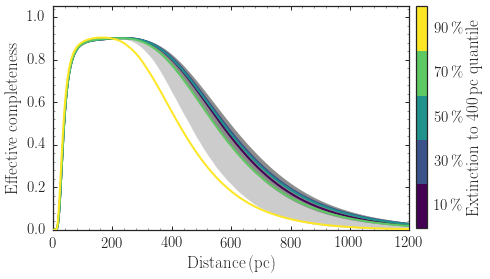

In [17]:
add_range= True
figsize(6,4)
cmap= cm.viridis
for ii,sptype in enumerate(plot_quants):
    bovy_plot.bovy_plot(10.**(0.2*dms+1.),esfs[ii],'-',
                        color=cmap(float(ii)/(len(plot_quants)-1)),
                        lw=2.,overplot=ii>0,zorder=3,
                        xlabel=r'$\mathrm{Distance}\,(\mathrm{pc})$',
                        ylabel=r'$\mathrm{Effective\ completeness}$',
                        xrange=[0.,1200.],
                        yrange=[0.,1.05])
if add_range:
    s_effsel= numpy.sort(tesf_ext._effsel_4vol,axis=0)
    pyplot.fill_between(tesf_ext._dists_4vol*1000.,
                        s_effsel[int(numpy.floor(0.05*tesf_ext._effsel_4vol.shape[0]))],s_effsel[-1],
                        color='0.8',zorder=1)
    pyplot.fill_between(tesf_ext._dists_4vol*1000.,
                        s_effsel[int(numpy.floor(0.32*tesf_ext._effsel_4vol.shape[0]))],s_effsel[-1],
                        color='0.55',zorder=2)
# Add colorbar
ticknames= [r'$%.0f\,\%%$' % (100.*quant) for quant in plot_quants]
ticks= numpy.arange(len(plot_quants))
fig= pyplot.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.965, 0.13, 0.025, 0.77])
tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
sm = pyplot.cm.ScalarMappable(cmap=tcmap,
                              norm=pyplot.Normalize(vmin=-0.5,vmax=len(plot_quants)-0.5))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,
                   ticks=ticks)
cbar.set_ticklabels(ticknames)
cbar.set_label(r'$\mathrm{Extinction\ to\ 400\,pc\ quantile}$')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_f_distance_extinction.pdf'),
                bbox_inches='tight')

Large extinction can have a large effect, but overall the effect of extinction is small.

## Volume completeness for different stellar types.

Now that we understand the completeness as a function of distance, we can determine the volume completeness of different parts of space. We start with the no-extinction case and look at a cylindrical volume centered on the $(X,Y)$ position of the Sun in different slices below and above the plane. We first consider a cylinder with a radius of 50 pc:

In [18]:
# For tesf.volume, we need an indicator function that is 1 within the volume considered and 0 outside
def cyl_vol_func(X,Y,Z,xymin=0.,xymax=0.15,zmin=0.05,zmax=0.15):
    """A function that bins in cylindrical annuli around the Sun"""
    xy= numpy.sqrt(X**2.+Y**2.)
    out= numpy.zeros_like(X)
    out[(xy >= xymin)*(xy < xymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out
# Now compute the volume fraction
dxy, dz= 0.05, 0.05
zs= numpy.arange(-1.75,1.75+dz/3.,dz/3.)
SpTypes= ['A','F','G','K','M']
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
savefilename= 'effvol_cyl_50pc.sav'
tesf_savefilename_base= '/geir_data/scr/bovy/tgas-completeness/tgEffsel'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        evfs= pickle.load(savefile)
        evfs_ext= pickle.load(savefile)
else:
    evfs= numpy.empty((len(SpTypes),len(zs)))
    evfs_ext= numpy.empty((len(SpTypes),len(zs)))
    for ii,sptype in enumerate(SpTypes):
        print(sptype)
        t_tesf_savefilename= tesf_savefilename_base+'_%s.sav' % sptype
        if os.path.exists(t_tesf_savefilename):
            with open(t_tesf_savefilename,'rb') as savefile:
                tesf_ext= pickle.load(savefile)
            MJ= tesf_ext._MJ
            JK= tesf_ext._JK
        else:
            # Find this stellar type
            jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
            if sptype == 'M':
                jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
            else:
                jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
            jmin= main_sequence_cut_r(jkmax)
            jmax= main_sequence_cut_r(jkmin)
            good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                            *(mj < main_sequence_cut_r(jk,tight=True,low=True))\
                            *(mj > main_sequence_cut_r(jk,tight=True))
            # sample MJ,JK randomly
            MJ= mj[good_sampling]
            JK= jk[good_sampling]
            nMJ= 1000
            if numpy.sum(good_sampling) > nMJ:
                keep= numpy.random.permutation(numpy.sum(good_sampling))[:nMJ]
                MJ= MJ[keep]
                JK= JK[keep]
            tesf_ext._MJ= MJ
            tesf_ext._JK= JK
        tesf._MJ= MJ
        tesf._JK= JK
        ndists=(2501*((sptype == 'B') + (sptype == 'A'))
               +1001*((sptype == 'F') + (sptype == 'G') + (sptype == 'K') + (sptype == 'M')))
        for jj,zz in enumerate(zs):    
            evfs[ii,jj]= tesf.volume(lambda x,y,z: cyl_vol_func(x,y,z,xymax=dxy,zmin=zz-dz/2.,zmax=zz+dz/2.),
                                     ndists=ndists,xyz=True,relative=True)
            evfs_ext[ii,jj]= tesf_ext.volume(lambda x,y,z: cyl_vol_func(x,y,z,xymax=dxy,zmin=zz-dz/2.,zmax=zz+dz/2.),
                                             ndists=ndists,xyz=True,ncpu=30,relative=True)
        if not os.path.exists(t_tesf_savefilename):
            save_pickles(t_tesf_savefilename,tesf_ext)
    save_pickles(savefilename,evfs,evfs_ext)

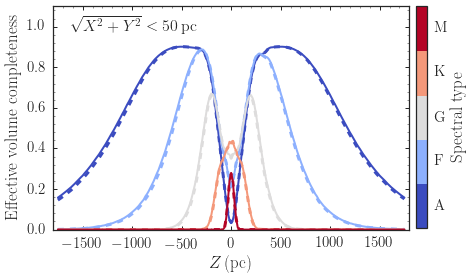

In [19]:
figsize(6,4)
cmap= cm.coolwarm
for ii,sptype in enumerate(SpTypes):
    bovy_plot.bovy_plot(zs*1000.,evfs[ii],'-',
                        color=cmap(float(ii)/(len(SpTypes)-1)),
                        lw=2.,overplot=ii>0,zorder=2,
                        xlabel=r'$Z\,(\mathrm{pc})$',
                        ylabel=r'$\mathrm{Effective\ volume\ completeness}$',
                        xrange=[-1800,1800],
                        yrange=[0.0,1.1])
for ii,sptype in enumerate(SpTypes):
    bovy_plot.bovy_plot(zs*1000.,evfs_ext[ii],'--',
                        color=cmap(float(ii)/(len(SpTypes)-1)),
                        lw=3.,overplot=True,zorder=1)
bovy_plot.bovy_text(r'$\sqrt{X^2+Y^2} < 50\,\mathrm{pc}$',size=16.,top_left=True)
# Add colorbar
ticknames= [r'$\mathrm{%s}$' % sptype for sptype in SpTypes]
ticks= numpy.arange(len(SpTypes))
fig= pyplot.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.965, 0.13, 0.025, 0.77])
tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
sm = pyplot.cm.ScalarMappable(cmap=tcmap,
                              norm=pyplot.Normalize(vmin=-0.5,vmax=len(SpTypes)-0.5))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,
                   ticks=ticks)
cbar.set_ticklabels(ticknames)
cbar.set_label(r'$\mathrm{Spectral\ type}$')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_cyl_50pc.pdf'),
                bbox_inches='tight')

How about a cylinder with a radius of 250 pc?

In [20]:
# For tesf.volume, we need an indicator function that is 1 within the volume considered and 0 outside
def cyl_vol_func(X,Y,Z,xymin=0.,xymax=0.15,zmin=0.05,zmax=0.15):
    """A function that bins in cylindrical annuli around the Sun"""
    xy= numpy.sqrt(X**2.+Y**2.)
    out= numpy.zeros_like(X)
    out[(xy >= xymin)*(xy < xymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out
# Now compute the volume fraction
dxy, dz= 0.25, 0.05
zs= numpy.arange(-1.75,1.75+dz/3.,dz/3.)
SpTypes= ['A','F','G','K','M']
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
savefilename= 'effvol_cyl_250pc.sav'
tesf_savefilename_base= '/geir_data/scr/bovy/tgas-completeness/tgEffsel'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        evfs= pickle.load(savefile)
        evfs_ext= pickle.load(savefile)
else:
    evfs= numpy.empty((len(SpTypes),len(zs)))
    evfs_ext= numpy.empty((len(SpTypes),len(zs)))
    for ii,sptype in enumerate(SpTypes):
        print(sptype)
        t_tesf_savefilename= tesf_savefilename_base+'_%s.sav' % sptype
        if os.path.exists(t_tesf_savefilename):
            with open(t_tesf_savefilename,'rb') as savefile:
                tesf_ext= pickle.load(savefile)
            MJ= tesf_ext._MJ
            JK= tesf_ext._JK
        else:
            # Find this stellar type
            jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
            if sptype == 'M':
                jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
            else:
                jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
            jmin= main_sequence_cut_r(jkmax)
            jmax= main_sequence_cut_r(jkmin)
            good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                            *(mj < main_sequence_cut_r(jk,tight=True,low=True))\
                            *(mj > main_sequence_cut_r(jk,tight=True))
            # sample MJ,JK randomly
            MJ= mj[good_sampling]
            JK= jk[good_sampling]
            nMJ= 1000
            if numpy.sum(good_sampling) > nMJ:
                keep= numpy.random.permutation(numpy.sum(good_sampling))[:nMJ]
                MJ= MJ[keep]
                JK= JK[keep]
            tesf_ext._MJ= MJ
            tesf_ext._JK= JK
        tesf._MJ= MJ
        tesf._JK= JK
        ndists=(2501*((sptype == 'B') + (sptype == 'A'))
                +1001*((sptype == 'F') + (sptype == 'G') + (sptype == 'K') + (sptype == 'M')))
        for jj,zz in enumerate(zs):
            evfs[ii,jj]= tesf.volume(lambda x,y,z: cyl_vol_func(x,y,z,xymax=dxy,zmin=zz-dz/2.,zmax=zz+dz/2.),
                                     ndists=ndists,xyz=True,relative=True)
            evfs_ext[ii,jj]= tesf_ext.volume(lambda x,y,z: cyl_vol_func(x,y,z,xymax=dxy,zmin=zz-dz/2.,zmax=zz+dz/2.),
                                             ndists=ndists,xyz=True,ncpu=30,relative=True)
        if not os.path.exists(t_tesf_savefilename):
            save_pickles(t_tesf_savefilename,tesf_ext)
    # Make fractional volume
    save_pickles(savefilename,evfs,evfs_ext)

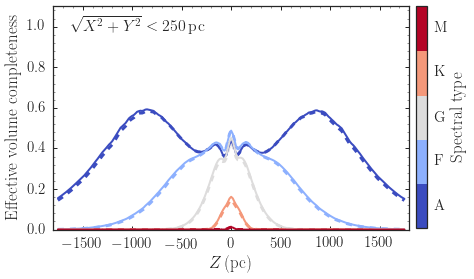

In [21]:
figsize(6,4)
cmap= cm.coolwarm
for ii,sptype in enumerate(SpTypes):
    bovy_plot.bovy_plot(zs*1000.,evfs[ii],'-',
                        color=cmap(float(ii)/(len(SpTypes)-1)),
                        lw=2.,overplot=ii>0,
                        xlabel=r'$Z\,(\mathrm{pc})$',
                        ylabel=r'$\mathrm{Effective\ volume\ completeness}$',
                        xrange=[-1800,1800],
                        yrange=[0.0,1.1])
for ii,sptype in enumerate(SpTypes):
    bovy_plot.bovy_plot(zs*1000.,evfs_ext[ii],'--',
                        color=cmap(float(ii)/(len(SpTypes)-1)),
                        lw=3.,overplot=True,zorder=1)
#pyplot.xscale('symlog',linthreshx=100.)
bovy_plot.bovy_text(r'$\sqrt{X^2+Y^2} < 250\,\mathrm{pc}$',size=16.,top_left=True)
# Add colorbar
ticknames= [r'$\mathrm{%s}$' % sptype for sptype in SpTypes]
ticks= numpy.arange(len(SpTypes))
fig= pyplot.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.965, 0.13, 0.025, 0.77])
tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
sm = pyplot.cm.ScalarMappable(cmap=tcmap,
                              norm=pyplot.Normalize(vmin=-0.5,vmax=len(SpTypes)-0.5))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,
                   ticks=ticks)
cbar.set_ticklabels(ticknames)
cbar.set_label(r'$\mathrm{Spectral\ type}$')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_cyl_250pc.pdf'),
                bbox_inches='tight')

Next, we'll look at the effective volume completeness in the $X-Y$ plane in slices in z:

In [22]:
# For tesf.volume, we need an indicator function that is 1 within the volume considered and 0 outside
def rect_vol_func(X,Y,Z,xmin=0.,xmax=0.15,ymin=0.,ymax=0.15,zmin=0.05,zmax=0.15):
    """A function that bins in rectangular bins in Galactic coordinates around the Sun"""
    out= numpy.zeros_like(X)
    out[(X >= xmin)*(X < xmax)*(Y >= ymin)*(Y < ymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out
def _calc_rectxy_oney(tesf,ndists,xx,yy,zz,relative=True):
    return tesf.volume(lambda x,y,z: rect_vol_func(x,y,z,
                                                   xmin=xx-dx/2.,xmax=xx+dx/2.,
                                                   ymin=yy-dy/2.,ymax=yy+dy/2.,
                                                   zmin=zz-dz/2.,zmax=zz+dz/2.),
                       ndists=ndists,xyz=True,relative=relative)
# Now compute the volume fraction
dx, dy, dz= 0.1, 0.1, 0.1
xs= numpy.arange(-1.75,1.75+dx/5.,dx/5.)
ys= numpy.arange(-1.75,1.75+dy/5.,dy/5.)
"""
xs= numpy.arange(-1.75,1.75+dx,dx)
ys= numpy.arange(-1.75,1.75+dy,dy)
"""
z_slices= [-0.2,-0.1,0.,0.1,0.2]
SpTypes= ['A','F','G','K','M']
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
savefilename= 'effvol_rectxy.sav'
tesf_savefilename_base= '/geir_data/scr/bovy/tgas-completeness/tgEffsel'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        evfs= pickle.load(savefile)
        evfs_ext= pickle.load(savefile)
        evfs_uni= pickle.load(savefile)
else:
    evfs= numpy.empty((len(SpTypes),len(z_slices),len(xs),len(ys)))
    evfs_ext= numpy.empty((len(SpTypes),len(z_slices),len(xs),len(ys)))
    evfs_uni= numpy.empty((len(SpTypes),len(z_slices),len(xs),len(ys)))
    for ii,sptype in enumerate(SpTypes):
        print(sptype)
        t_tesf_savefilename= tesf_savefilename_base+'_%s.sav' % sptype
        if os.path.exists(t_tesf_savefilename):
            with open(t_tesf_savefilename,'rb') as savefile:
                tesf_ext= pickle.load(savefile)
            MJ= tesf_ext._MJ
            JK= tesf_ext._JK
        else:
            # Find this stellar type
            jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
            if sptype == 'M':
                jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
            else:
                jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
            jmin= main_sequence_cut_r(jkmax)
            jmax= main_sequence_cut_r(jkmin)
            good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                            *(mj < main_sequence_cut_r(jk,tight=True,low=True))\
                            *(mj > main_sequence_cut_r(jk,tight=True))
            # sample MJ,JK randomly
            MJ= mj[good_sampling]
            JK= jk[good_sampling]
            nMJ= 1000
            if numpy.sum(good_sampling) > nMJ:
                keep= numpy.random.permutation(numpy.sum(good_sampling))[:nMJ]
                MJ= MJ[keep]
                JK= JK[keep]
            tesf_ext._MJ= MJ
            tesf_ext._JK= JK
        tesf._MJ= MJ
        tesf._JK= JK
        ndists=(2501*((sptype == 'B') + (sptype == 'A'))
                +1001*((sptype == 'F') + (sptype == 'G') + (sptype == 'K') + (sptype == 'M')))
        # Need to calculate one first to store the uniform-completeness object for relative=True 
        # (I know, but re-saving the objects will take a long time ...)
        dum= tesf.volume(lambda x,y,z: rect_vol_func(x,y,z,xmin=xs[0]-dx/2.,xmax=xs[0]+dx/2.,
                                                           ymin=ys[0]-dy/2.,ymax=ys[0]+dy/2.,
                                                           zmin=z_slices[0]-dz/2.,zmax=z_slices[0]+dz/2.),
                                                     ndists=ndists,xyz=True,relative=True)
        dum= tesf_ext.volume(lambda x,y,z: rect_vol_func(x,y,z,xmin=xs[0]-dx/2.,xmax=xs[0]+dx/2.,
                                                           ymin=ys[0]-dy/2.,ymax=ys[0]+dy/2.,
                                                           zmin=z_slices[0]-dz/2.,zmax=z_slices[0]+dz/2.),
                                                     ndists=ndists,xyz=True,relative=True)
        for jj,zz in enumerate(z_slices):
            print(jj)
            for kk, xx in tqdm.tqdm(enumerate(xs),total=len(xs)):
                evfs[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf,ndists,xx,ys[w],zz,
                                                                                   relative=False),
                                                        range(len(ys)),numcores=30))
                evfs_ext[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf_ext,ndists,xx,ys[w],zz,
                                                                                   relative=False),
                                                        range(len(ys)),numcores=30))
                evfs_uni[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf._tgasEffSelUniform,
                                                                                    ndists,xx,ys[w],zz,
                                                                                    relative=False),
                                                        range(len(ys)),numcores=30))
        if not os.path.exists(t_tesf_savefilename):
            save_pickles(t_tesf_savefilename,tesf_ext)
    # Make relative volume completeness
    evfs/= evfs_uni
    evfs_ext/= evfs_uni
    save_pickles(savefilename,evfs,evfs_ext,evfs_uni)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1210: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):



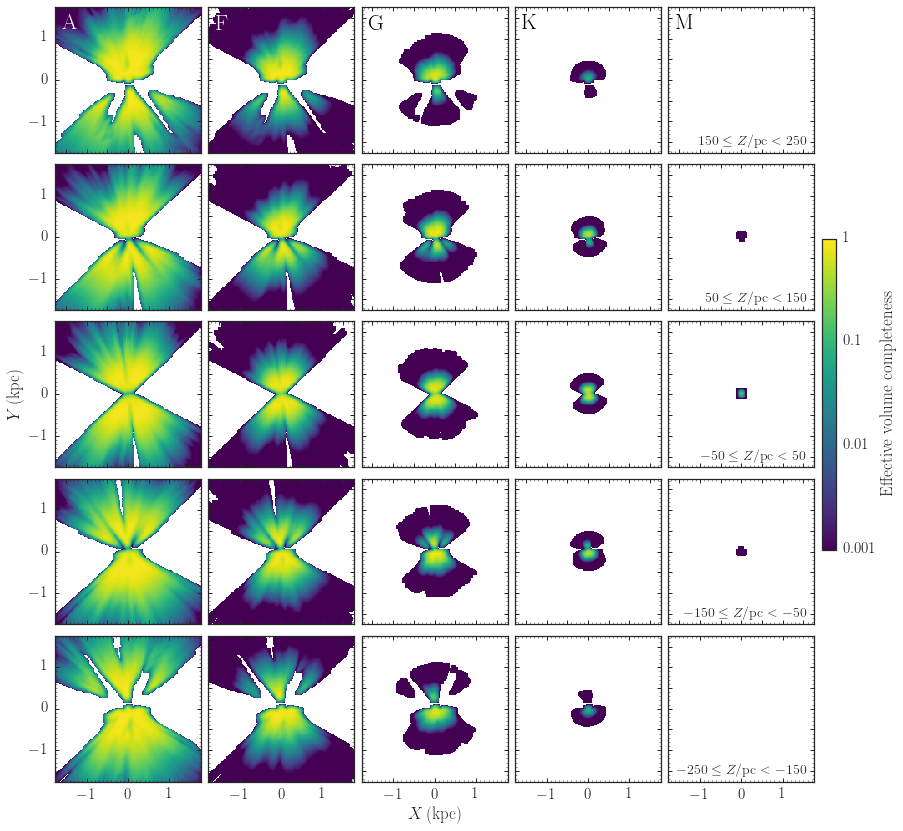

In [23]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(14,14)
gs= gridspec.GridSpec(len(z_slices),len(SpTypes)+1,width_ratios=[1.,1.,1.,1.,1,0.1],
                      hspace=0.03,wspace=0.06)
# So we can put the colorbar starting in the middle of one of the panels...
gs2= gridspec.GridSpec(len(z_slices)*2,len(SpTypes)+1,width_ratios=[1.,1.,1.,1.,1,0.1],
                      hspace=0.03,wspace=0.06)
vmin, vmax= -3, 0
#evfs_ext[evfs_ext < 10.**vmin]= numpy.nan
for ii in range(len(z_slices)):
    for jj in range(len(SpTypes)):
        subplot(gs[len(z_slices)-ii-1,jj])
        bovy_plot.bovy_dens2d(numpy.log10(evfs_ext[jj,ii]).T,origin='lower',gcf=True,
                              cmap='viridis',interpolation='nearest',
                              xrange=[xs[0]-(xs[1]-xs[0])/2.,xs[-1]+(xs[1]-xs[0])/2.],
                              yrange=[ys[0]-(ys[1]-ys[0])/2.,ys[-1]+(ys[1]-ys[0])/2.],
                              vmin=vmin,vmax=vmax)
        if not ii == 0:
            gca().xaxis.set_major_formatter(NullFormatter())
        else:
            gca().set_xticks([-1.,0.,1.])
            if ii == 0 and jj == 2:
                pyplot.xlabel(r'$X\,(\mathrm{kpc})$')
        if not jj == 0:
            gca().yaxis.set_major_formatter(NullFormatter())
        else:
            gca().set_yticks([-1.,0.,1.])
            if jj == 0 and ii == 2:
                pyplot.ylabel(r'$Y\,(\mathrm{kpc})$')
        if jj == len(SpTypes)-1:
            bovy_plot.bovy_text(r'$%.0f \leq Z/\mathrm{pc} < %.0f$' \
                                % (1000.*(z_slices[ii]-dz/2.),1000.*(z_slices[ii]+dz/2.)),
                               bottom_right=True,size=14.)
        if ii == len(z_slices)-1:
            lcolor= 'k'
            if jj < 2: lcolor= 'w'
            bovy_plot.bovy_text(r'$\mathrm{%s}$' % SpTypes[jj],size=22.,top_left=True,color=lcolor)
# Add colorbar
subplot(gs2[3:7,5])
ticks= [10.**x for x in range(vmin,vmax+1)]
ticknames= [r'$%g$' % x for x in ticks]
cmap= cm.viridis
# Not sure what I'm doing wrong here
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=LogNorm(vmin=10.**vmin,vmax=10.**vmax))
sm._A = []
cbar= pyplot.colorbar(sm,cax=gca(),use_gridspec=True,ticks=ticks,format=LogFormatter(10.))
cbar.set_ticklabels(ticknames)
cbar.set_label(r'$\mathrm{Effective\ volume\ completeness}$')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_rectxy.pdf'),
                bbox_inches='tight')

Next, we'll look at the effective volume completeness in the $Y-Z$ plane in slices in $X$:

In [24]:
# For tesf.volume, we need an indicator function that is 1 within the volume considered and 0 outside
def rect_vol_func(X,Y,Z,xmin=0.,xmax=0.15,ymin=0.,ymax=0.15,zmin=0.05,zmax=0.15):
    """A function that bins in rectangular bins in Galactic coordinates around the Sun"""
    out= numpy.zeros_like(X)
    out[(X >= xmin)*(X < xmax)*(Y >= ymin)*(Y < ymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out
def _calc_rectxy_oney(tesf,ndists,xx,yy,zz,relative=True):
    return tesf.volume(lambda x,y,z: rect_vol_func(x,y,z,
                                                   xmin=xx-dx/2.,xmax=xx+dx/2.,
                                                   ymin=yy-dy/2.,ymax=yy+dy/2.,
                                                   zmin=zz-dz/2.,zmax=zz+dz/2.),
                       ndists=ndists,xyz=True,relative=relative)
# Now compute the volume fraction
dx, dy, dz= 0.1, 0.1, 0.1
ys= numpy.arange(-1.75,1.75+dy/5.,dy/5.)
zs= numpy.arange(-1.75,1.75+dz/5.,dz/5.)
"""
ys= numpy.arange(-1.75,1.75+dy,dy)
zs= numpy.arange(-1.75,1.75+dz,dz)
"""
x_slices= [-0.2,-0.1,0.,0.1,0.2]
SpTypes= ['A','F','G','K','M']
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
savefilename= 'effvol_rectyz.sav'
tesf_savefilename_base= '/geir_data/scr/bovy/tgas-completeness/tgEffsel'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        evfs= pickle.load(savefile)
        evfs_ext= pickle.load(savefile)
        evfs_uni= pickle.load(savefile)
else:
    evfs= numpy.empty((len(SpTypes),len(x_slices),len(ys),len(zs)))
    evfs_ext= numpy.empty((len(SpTypes),len(x_slices),len(ys),len(zs)))
    evfs_uni= numpy.empty((len(SpTypes),len(x_slices),len(ys),len(zs)))
    for ii,sptype in enumerate(SpTypes):
        print(sptype)
        t_tesf_savefilename= tesf_savefilename_base+'_%s.sav' % sptype
        if os.path.exists(t_tesf_savefilename):
            with open(t_tesf_savefilename,'rb') as savefile:
                tesf_ext= pickle.load(savefile)
            MJ= tesf_ext._MJ
            JK= tesf_ext._JK
        else:
            # Find this stellar type
            jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
            if sptype == 'M':
                jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
            else:
                jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
            jmin= main_sequence_cut_r(jkmax)
            jmax= main_sequence_cut_r(jkmin)
            good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                            *(mj < main_sequence_cut_r(jk,tight=True,low=True))\
                            *(mj > main_sequence_cut_r(jk,tight=True))
            # sample MJ,JK randomly
            MJ= mj[good_sampling]
            JK= jk[good_sampling]
            nMJ= 1000
            if numpy.sum(good_sampling) > nMJ:
                keep= numpy.random.permutation(numpy.sum(good_sampling))[:nMJ]
                MJ= MJ[keep]
                JK= JK[keep]
            tesf_ext._MJ= MJ
            tesf_ext._JK= JK
        tesf._MJ= MJ
        tesf._JK= JK
        ndists=(2501*((sptype == 'B') + (sptype == 'A'))
                +1001*((sptype == 'F') + (sptype == 'G') + (sptype == 'K') + (sptype == 'M')))
        # Need to calculate one first to store the uniform-completeness object for relative=True 
        # (I know, but re-saving the objects will take a long time ...)
        dum= tesf.volume(lambda x,y,z: rect_vol_func(x,y,z,xmin=x_slices[0]-dx/2.,xmax=x_slices[0]+dx/2.,
                                                           ymin=ys[0]-dy/2.,ymax=ys[0]+dy/2.,
                                                           zmin=zs[0]-dz/2.,zmax=zs[0]+dz/2.),
                                                     ndists=ndists,xyz=True,relative=True)
        dum= tesf_ext.volume(lambda x,y,z: rect_vol_func(x,y,z,xmin=x_slices[0]-dx/2.,xmax=x_slices[0]+dx/2.,
                                                           ymin=ys[0]-dy/2.,ymax=ys[0]+dy/2.,
                                                           zmin=zs[0]-dz/2.,zmax=zs[0]+dz/2.),
                                                     ndists=ndists,xyz=True,relative=True)
        for jj,xx in enumerate(x_slices):
            print(jj)
            for kk, yy in tqdm.tqdm(enumerate(ys),total=len(ys)):
                evfs[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf,ndists,xx,yy,zs[w],
                                                                                   relative=False),
                                                        range(len(zs)),numcores=30))
                evfs_ext[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf_ext,ndists,xx,yy,zs[w],
                                                                                   relative=False),
                                                        range(len(zs)),numcores=30))
                evfs_uni[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf._tgasEffSelUniform,
                                                                                    ndists,xx,yy,zs[w],
                                                                                    relative=False),
                                                        range(len(zs)),numcores=30))
        if not os.path.exists(t_tesf_savefilename):
            save_pickles(t_tesf_savefilename,tesf_ext)
    # Make relative volume completeness
    evfs/= evfs_uni
    evfs_ext/= evfs_uni
    save_pickles(savefilename,evfs,evfs_ext,evfs_uni)

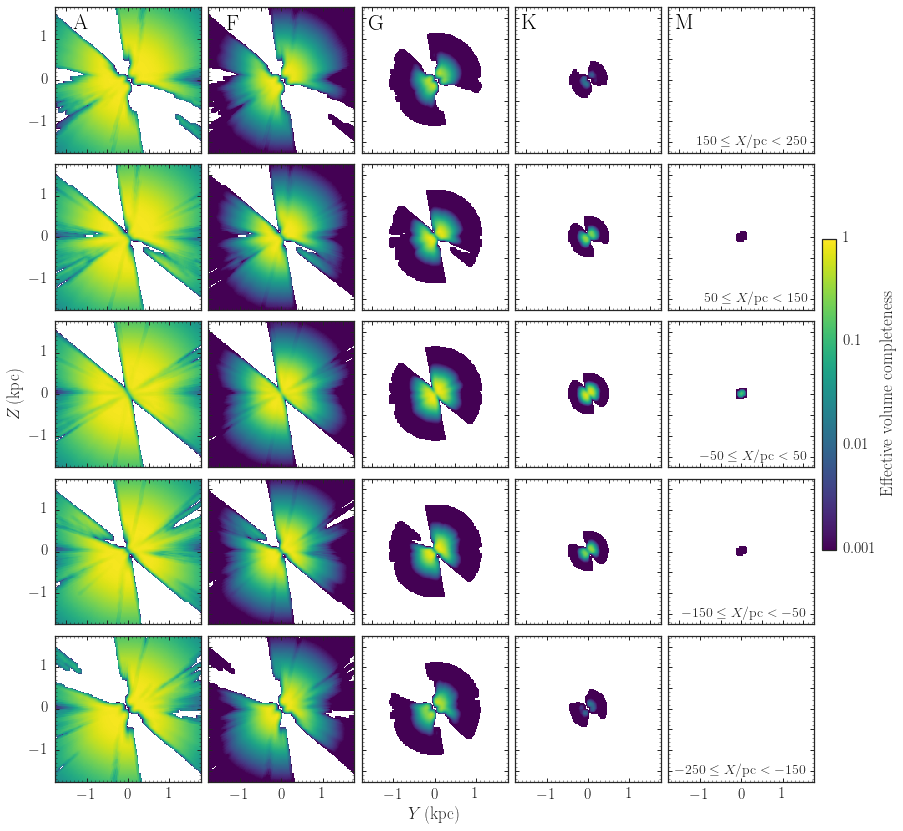

In [25]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(14,14)
gs= gridspec.GridSpec(len(z_slices),len(SpTypes)+1,width_ratios=[1.,1.,1.,1.,1,0.1],
                      hspace=0.03,wspace=0.06)
# So we can put the colorbar starting in the middle of one of the panels...
gs2= gridspec.GridSpec(len(z_slices)*2,len(SpTypes)+1,width_ratios=[1.,1.,1.,1.,1,0.1],
                      hspace=0.03,wspace=0.06)
vmin, vmax= -3, 0
#evfs_ext[evfs_ext < 10.**vmin]= numpy.nan
for ii in range(len(z_slices)):
    for jj in range(len(SpTypes)):
        subplot(gs[len(z_slices)-ii-1,jj])
        bovy_plot.bovy_dens2d(numpy.log10(evfs_ext[jj,ii]).T,origin='lower',gcf=True,
                              cmap='viridis',interpolation='nearest',
                              xrange=[ys[0]-(ys[1]-ys[0])/2.,ys[-1]+(ys[1]-ys[0])/2.],
                              yrange=[zs[0]-(zs[1]-zs[0])/2.,zs[-1]+(zs[1]-zs[0])/2.],
                              vmin=vmin,vmax=vmax)
        if not ii == 0:
            gca().xaxis.set_major_formatter(NullFormatter())
        else:
            gca().set_xticks([-1.,0.,1.])
            if ii == 0 and jj == 2:
                pyplot.xlabel(r'$Y\,(\mathrm{kpc})$')
        if not jj == 0:
            gca().yaxis.set_major_formatter(NullFormatter())
        else:
            gca().set_yticks([-1.,0.,1.])
            if jj == 0 and ii == 2:
                pyplot.ylabel(r'$Z\,(\mathrm{kpc})$')
        if jj == len(SpTypes)-1:
            bovy_plot.bovy_text(r'$%.0f \leq X/\mathrm{pc} < %.0f$' \
                                % (1000.*(x_slices[ii]-dz/2.),1000.*(x_slices[ii]+dz/2.)),
                               bottom_right=True,size=14.)
        if ii == len(x_slices)-1:
            if jj < 2: 
                pyplot.annotate(r'$\mathrm{%s}$' % SpTypes[jj],(0.125,0.95),xycoords='axes fraction',
                        verticalalignment='top',size=22.,color='k')
            else:
                bovy_plot.bovy_text(r'$\mathrm{%s}$' % SpTypes[jj],size=22.,top_left=True,color='k')
# Add colorbar
subplot(gs2[3:7,5])
ticks= [10.**x for x in range(vmin,vmax+1)]
ticknames= [r'$%g$' % x for x in ticks]
cmap= cm.viridis
# Not sure what I'm doing wrong here
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=LogNorm(vmin=10.**vmin,vmax=10.**vmax))
sm._A = []
cbar= pyplot.colorbar(sm,cax=gca(),use_gridspec=True,ticks=ticks,format=LogFormatter(10.))
cbar.set_ticklabels(ticknames)
cbar.set_label(r'$\mathrm{Effective\ volume\ completeness}$')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_rectyz.pdf'),
                bbox_inches='tight')

## Effective volume completeness for giants

We can do the same along the giant branch, which gives:

In [26]:
# For tesf.volume, we need an indicator function that is 1 within the volume considered and 0 outside
def rect_vol_func(X,Y,Z,xmin=0.,xmax=0.15,ymin=0.,ymax=0.15,zmin=0.05,zmax=0.15):
    """A function that bins in rectangular bins in Galactic coordinates around the Sun"""
    out= numpy.zeros_like(X)
    out[(X >= xmin)*(X < xmax)*(Y >= ymin)*(Y < ymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out
def _calc_rectxy_oney(tesf,ndists,xx,yy,zz,relative=True):
    return tesf.volume(lambda x,y,z: rect_vol_func(x,y,z,
                                                   xmin=xx-dx/2.,xmax=xx+dx/2.,
                                                   ymin=yy-dy/2.,ymax=yy+dy/2.,
                                                   zmin=zz-dz/2.,zmax=zz+dz/2.),
                       ndists=ndists,xyz=True,relative=relative)
# Now compute the volume fraction
nMJ= 1000
ndists= 2501
dx, dy, dz= 0.1, 0.1, 0.1
xs= numpy.arange(-1.75,1.75+dx/5.,dx/5.)
ys= numpy.arange(-1.75,1.75+dy/5.,dy/5.)
"""
xs= numpy.arange(-1.75,1.75+dx,dx)
ys= numpy.arange(-1.75,1.75+dy,dy)
"""
z_slices= [-0.2,-0.1,0.,0.1,0.2]
SpTypes= ['subgiants','lower RGB','RC','upper RGB']
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
savefilename= 'effvol_rectxy_giants.sav'
tesf_savefilename_base= '/geir_data/scr/bovy/tgas-completeness/tgEffsel'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        evfs= pickle.load(savefile)
        evfs_ext= pickle.load(savefile)
        evfs_uni= pickle.load(savefile)
else:
    evfs= numpy.empty((len(SpTypes),len(z_slices),len(xs),len(ys)))
    evfs_ext= numpy.empty((len(SpTypes),len(z_slices),len(xs),len(ys)))
    evfs_uni= numpy.empty((len(SpTypes),len(z_slices),len(xs),len(ys)))
    for ii,sptype in enumerate(SpTypes):
        t_tesf_savefilename= tesf_savefilename_base+'_%s.sav' % sptype.replace(" ", "")
        print(sptype)
        if os.path.exists(t_tesf_savefilename):
            with open(t_tesf_savefilename,'rb') as savefile:
                tesf_ext= pickle.load(savefile)
            MJ= tesf_ext._MJ
            JK= tesf_ext._JK
        else:
            # Find this stellar type
            good_sampling= good_plx_indx*select_giants(sptype,jk,mj,tight=True)
            # sample MJ,JK randomly
            MJ= mj[good_sampling]
            JK= jk[good_sampling]
            if numpy.sum(good_sampling) > nMJ:
                keep= numpy.random.permutation(numpy.sum(good_sampling))[:nMJ]
                MJ= MJ[keep]
                JK= JK[keep]
            tesf_ext._MJ= MJ
            tesf_ext._JK= JK
        tesf._MJ= MJ
        tesf._JK= JK
        # Need to calculate one first to store the uniform-completeness object for relative=True 
        # (I know, but re-saving the objects will take a long time ...)
        dum= tesf.volume(lambda x,y,z: rect_vol_func(x,y,z,xmin=xs[0]-dx/2.,xmax=xs[0]+dx/2.,
                                                           ymin=ys[0]-dy/2.,ymax=ys[0]+dy/2.,
                                                           zmin=z_slices[0]-dz/2.,zmax=z_slices[0]+dz/2.),
                                                     ndists=ndists,xyz=True,relative=True)
        dum= tesf_ext.volume(lambda x,y,z: rect_vol_func(x,y,z,xmin=xs[0]-dx/2.,xmax=xs[0]+dx/2.,
                                                           ymin=ys[0]-dy/2.,ymax=ys[0]+dy/2.,
                                                           zmin=z_slices[0]-dz/2.,zmax=z_slices[0]+dz/2.),
                                                     ndists=ndists,xyz=True,relative=True,ncpu=30)
        if not os.path.exists(t_tesf_savefilename):
            delattr(tesf_ext,'_tgasEffSelUniform')
            save_pickles(t_tesf_savefilename,tesf_ext)
        for jj,zz in enumerate(z_slices):
            print(jj)
            for kk, xx in tqdm.tqdm(enumerate(xs),total=len(xs)):
                evfs[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf,ndists,xx,ys[w],zz,
                                                                                   relative=False),
                                                        range(len(ys)),numcores=30))
                evfs_ext[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf_ext,ndists,xx,ys[w],zz,
                                                                                   relative=False),
                                                        range(len(ys)),numcores=30))
                evfs_uni[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf._tgasEffSelUniform,
                                                                                    ndists,xx,ys[w],zz,
                                                                                    relative=False),
                                                        range(len(ys)),numcores=30))
    # Make relative volume completeness
    evfs/= evfs_uni
    evfs_ext/= evfs_uni
    save_pickles(savefilename,evfs,evfs_ext,evfs_uni)

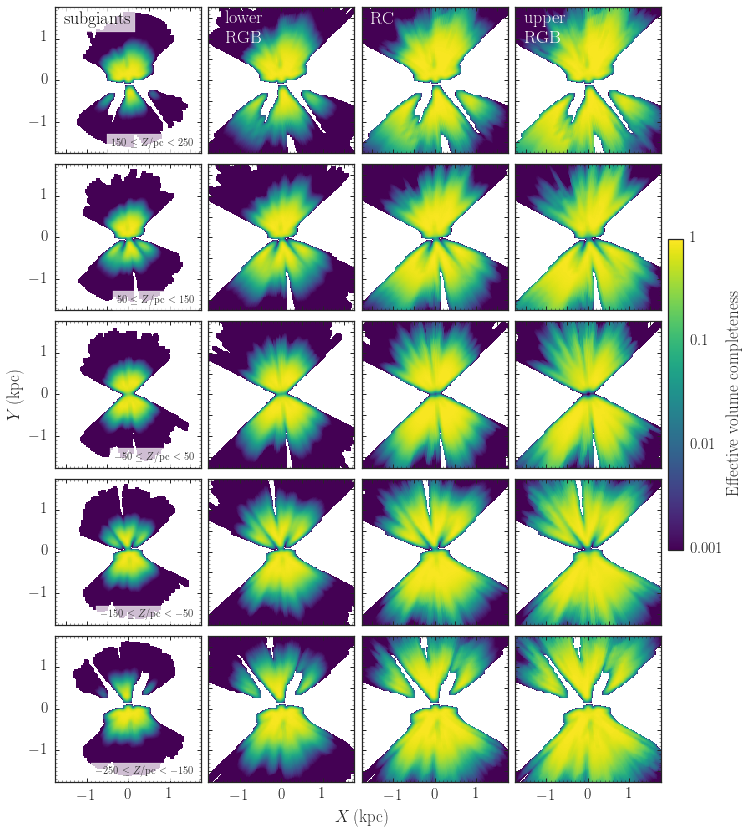

In [27]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(11.25,14)
gs= gridspec.GridSpec(len(z_slices),len(SpTypes)+1,width_ratios=[1.,1.,1.,1.,0.1],
                      hspace=0.03,wspace=0.06)
# So we can put the colorbar starting in the middle of one of the panels...
gs2= gridspec.GridSpec(len(z_slices)*2,len(SpTypes)+1,width_ratios=[1.,1.,1.,1.,0.1],
                      hspace=0.03,wspace=0.06)
vmin, vmax= -3, 0
#evfs_ext[evfs_ext < 10.**vmin]= numpy.nan
labels= [r'$\mathrm{subgiants}$',
         r'$\mathrm{lower}$'+'\n'+r'$\mathrm{RGB}$',
         r'$\mathrm{RC}$',
         r'$\mathrm{upper}$'+'\n'+r'$\mathrm{RGB}$']
for ii in range(len(z_slices)):
    for jj in range(len(SpTypes)):
        subplot(gs[len(z_slices)-ii-1,jj])
        bovy_plot.bovy_dens2d(numpy.log10(evfs_ext[jj,ii]).T,origin='lower',gcf=True,
                              cmap='viridis',interpolation='nearest',
                              xrange=[xs[0]-(xs[1]-xs[0])/2.,xs[-1]+(xs[1]-xs[0])/2.],
                              yrange=[ys[0]-(ys[1]-ys[0])/2.,ys[-1]+(ys[1]-ys[0])/2.],
                              vmin=vmin,vmax=vmax)
        if not ii == 0:
            gca().xaxis.set_major_formatter(NullFormatter())
        else:
            gca().set_xticks([-1.,0.,1.])
            if ii == 0 and jj == 2:
                pyplot.annotate(r'$X\,(\mathrm{kpc})$',(0.,-0.25),
                                xycoords='axes fraction',ha='center',va='center',
                                size=17.)
        if not jj == 0:
            gca().yaxis.set_major_formatter(NullFormatter())
        else:
            gca().set_yticks([-1.,0.,1.])
            if jj == 0 and ii == 2:
                pyplot.ylabel(r'$Y\,(\mathrm{kpc})$')
        if jj == 0:
            t= pyplot.annotate(r'$%.0f \leq Z/\mathrm{pc} < %.0f$' \
                                % (1000.*(z_slices[ii]-dz/2.),1000.*(z_slices[ii]+dz/2.)),
                               (0.95,0.05),xycoords='axes fraction',
                                horizontalalignment='right',size=10.5)
            t.set_bbox(dict(color='w',alpha=0.75, edgecolor='None'))
        if ii == len(z_slices)-1:
            lcolor= 'k'
            if jj > 0: lcolor= 'w'
            if jj == 0: 
                t= pyplot.text(-1.55,1.65,labels[jj],size=18.,color=lcolor,backgroundcolor='w',
                               ha='left',va='top')
                t.set_bbox(dict(color='w',alpha=0.75, edgecolor='None'))
            elif jj == 1:
                bovy_plot.bovy_text(-1.35,1.65,labels[jj],size=18.,color=lcolor,ha='left',va='top')
            else:
                bovy_plot.bovy_text(-1.55,1.65,labels[jj],size=18.,color=lcolor,ha='left',va='top')
# Add colorbar
subplot(gs2[3:7,4])
ticks= [10.**x for x in range(vmin,vmax+1)]
ticknames= [r'$%g$' % x for x in ticks]
cmap= cm.viridis
# Not sure what I'm doing wrong here
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=LogNorm(vmin=10.**vmin,vmax=10.**vmax))
sm._A = []
cbar= pyplot.colorbar(sm,cax=gca(),use_gridspec=True,ticks=ticks,format=LogFormatter(10.))
cbar.set_ticklabels(ticknames)
cbar.set_label(r'$\mathrm{Effective\ volume\ completeness}$')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_rectxy_giants.pdf'),
                bbox_inches='tight')

In [28]:
# For tesf.volume, we need an indicator function that is 1 within the volume considered and 0 outside
def rect_vol_func(X,Y,Z,xmin=0.,xmax=0.15,ymin=0.,ymax=0.15,zmin=0.05,zmax=0.15):
    """A function that bins in rectangular bins in Galactic coordinates around the Sun"""
    out= numpy.zeros_like(X)
    out[(X >= xmin)*(X < xmax)*(Y >= ymin)*(Y < ymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out
def _calc_rectxy_oney(tesf,ndists,xx,yy,zz,relative=True):
    return tesf.volume(lambda x,y,z: rect_vol_func(x,y,z,
                                                   xmin=xx-dx/2.,xmax=xx+dx/2.,
                                                   ymin=yy-dy/2.,ymax=yy+dy/2.,
                                                   zmin=zz-dz/2.,zmax=zz+dz/2.),
                       ndists=ndists,xyz=True,relative=relative)
# Now compute the volume fraction
dx, dy, dz= 0.1, 0.1, 0.1
nMJ= 1000
ndists= 2501
ys= numpy.arange(-1.75,1.75+dy/5.,dy/5.)
zs= numpy.arange(-1.75,1.75+dz/5.,dz/5.)
"""
ys= numpy.arange(-1.75,1.75+dy,dy)
zs= numpy.arange(-1.75,1.75+dz,dz)
"""
x_slices= [-0.2,-0.1,0.,0.1,0.2]
SpTypes= ['subgiants','lower RGB','RC','upper RGB']
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
savefilename= 'effvol_rectyz_giants.sav'
tesf_savefilename_base= '/geir_data/scr/bovy/tgas-completeness/tgEffsel'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        evfs= pickle.load(savefile)
        evfs_ext= pickle.load(savefile)
        evfs_uni= pickle.load(savefile)
else:
    evfs= numpy.empty((len(SpTypes),len(x_slices),len(ys),len(zs)))
    evfs_ext= numpy.empty((len(SpTypes),len(x_slices),len(ys),len(zs)))
    evfs_uni= numpy.empty((len(SpTypes),len(x_slices),len(ys),len(zs)))
    for ii,sptype in enumerate(SpTypes):
        t_tesf_savefilename= tesf_savefilename_base+'_%s.sav' % sptype.replace(" ", "")
        print(sptype)
        if os.path.exists(t_tesf_savefilename):
            with open(t_tesf_savefilename,'rb') as savefile:
                tesf_ext= pickle.load(savefile)
            MJ= tesf_ext._MJ
            JK= tesf_ext._JK
        else:
            # Find this stellar type
            good_sampling= good_plx_indx*select_giants(sptype,jk,mj,tight=True)
            # sample MJ,JK randomly
            MJ= mj[good_sampling]
            JK= jk[good_sampling]
            if numpy.sum(good_sampling) > nMJ:
                keep= numpy.random.permutation(numpy.sum(good_sampling))[:nMJ]
                MJ= MJ[keep]
                JK= JK[keep]
            tesf_ext._MJ= MJ
            tesf_ext._JK= JK
        tesf._MJ= MJ
        tesf._JK= JK
        # Need to calculate one first to store the uniform-completeness object for relative=True 
        # (I know, but re-saving the objects will take a long time ...)
        dum= tesf.volume(lambda x,y,z: rect_vol_func(x,y,z,xmin=x_slices[0]-dx/2.,xmax=x_slices[0]+dx/2.,
                                                           ymin=ys[0]-dy/2.,ymax=ys[0]+dy/2.,
                                                           zmin=zs[0]-dz/2.,zmax=zs[0]+dz/2.),
                                                     ndists=ndists,xyz=True,relative=True)
        dum= tesf_ext.volume(lambda x,y,z: rect_vol_func(x,y,z,xmin=x_slices[0]-dx/2.,xmax=x_slices[0]+dx/2.,
                                                           ymin=ys[0]-dy/2.,ymax=ys[0]+dy/2.,
                                                           zmin=zs[0]-dz/2.,zmax=zs[0]+dz/2.),
                                                     ndists=ndists,xyz=True,relative=True)
        for jj,xx in enumerate(x_slices):
            print(jj)
            for kk, yy in tqdm.tqdm(enumerate(ys),total=len(ys)):
                evfs[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf,ndists,xx,yy,zs[w],
                                                                                   relative=False),
                                                        range(len(zs)),numcores=30))
                evfs_ext[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf_ext,ndists,xx,yy,zs[w],
                                                                                   relative=False),
                                                        range(len(zs)),numcores=30))
                evfs_uni[ii,jj,kk]= numpy.array(multi.parallel_map(\
                                                        lambda w: _calc_rectxy_oney(tesf._tgasEffSelUniform,
                                                                                    ndists,xx,yy,zs[w],
                                                                                    relative=False),
                                                        range(len(zs)),numcores=30))
        if not os.path.exists(t_tesf_savefilename):
            save_pickles(t_tesf_savefilename,tesf_ext)
    # Make relative volume completeness
    evfs/= evfs_uni
    evfs_ext/= evfs_uni
    save_pickles(savefilename,evfs,evfs_ext,evfs_uni)

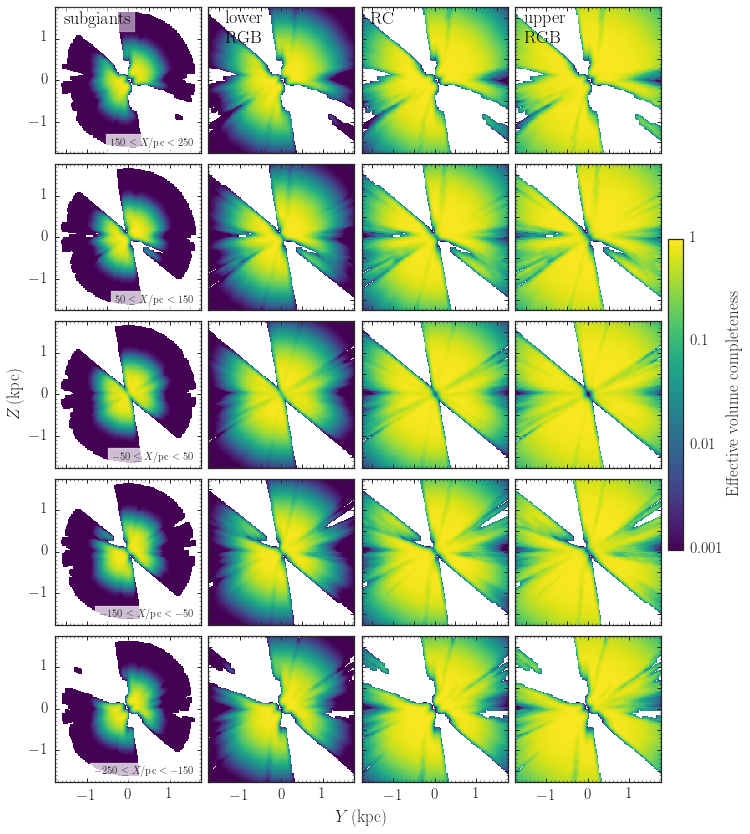

In [29]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(11.25,14)
gs= gridspec.GridSpec(len(x_slices),len(SpTypes)+1,width_ratios=[1.,1.,1.,1.,0.1],
                      hspace=0.03,wspace=0.06)
# So we can put the colorbar starting in the middle of one of the panels...
gs2= gridspec.GridSpec(len(x_slices)*2,len(SpTypes)+1,width_ratios=[1.,1.,1.,1.,0.1],
                      hspace=0.03,wspace=0.06)
vmin, vmax= -3, 0
#evfs_ext[evfs_ext < 10.**vmin]= numpy.nan
labels= [r'$\mathrm{subgiants}$',
         r'$\mathrm{lower}$'+'\n'+r'$\mathrm{RGB}$',
         r'$\mathrm{RC}$',
         r'$\mathrm{upper}$'+'\n'+r'$\mathrm{RGB}$']
for ii in range(len(x_slices)):
    for jj in range(len(SpTypes)):
        subplot(gs[len(x_slices)-ii-1,jj])
        bovy_plot.bovy_dens2d(numpy.log10(evfs_ext[jj,ii]).T,origin='lower',gcf=True,
                              cmap='viridis',interpolation='nearest',
                              xrange=[ys[0]-(ys[1]-ys[0])/2.,ys[-1]+(ys[1]-ys[0])/2.],
                              yrange=[zs[0]-(zs[1]-zs[0])/2.,zs[-1]+(zs[1]-zs[0])/2.],
                              vmin=vmin,vmax=vmax)
        if not ii == 0:
            gca().xaxis.set_major_formatter(NullFormatter())
        else:
            gca().set_xticks([-1.,0.,1.])
            if ii == 0 and jj == 2:
                pyplot.annotate(r'$Y\,(\mathrm{kpc})$',(0.,-0.25),
                                xycoords='axes fraction',ha='center',va='center',
                                size=17.)
        if not jj == 0:
            gca().yaxis.set_major_formatter(NullFormatter())
        else:
            gca().set_yticks([-1.,0.,1.])
            if jj == 0 and ii == 2:
                pyplot.ylabel(r'$Z\,(\mathrm{kpc})$')
        if jj == 0:
            t= pyplot.annotate(r'$%.0f \leq X/\mathrm{pc} < %.0f$' \
                                % (1000.*(x_slices[ii]-dz/2.),1000.*(x_slices[ii]+dz/2.)),
                               (0.95,0.05),xycoords='axes fraction',
                                horizontalalignment='right',size=10.5)
            t.set_bbox(dict(color='w',alpha=0.75, edgecolor='None'))
        if ii == len(x_slices)-1:
            lcolor= 'k'
            if jj > 0: lcolor= 'k'
            if jj == 0: 
                t= pyplot.text(-1.55,1.65,labels[jj],size=18.,color=lcolor,backgroundcolor='w',
                               ha='left',va='top')
                t.set_bbox(dict(color='w',alpha=0.5, edgecolor='None'))
            elif jj == 1:
                bovy_plot.bovy_text(-1.35,1.65,labels[jj],size=18.,color=lcolor,ha='left',va='top')
            else:
                bovy_plot.bovy_text(-1.55,1.65,labels[jj],size=18.,color=lcolor,ha='left',va='top')
# Add colorbar
subplot(gs2[3:7,4])
ticks= [10.**x for x in range(vmin,vmax+1)]
ticknames= [r'$%g$' % x for x in ticks]
cmap= cm.viridis
# Not sure what I'm doing wrong here
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=LogNorm(vmin=10.**vmin,vmax=10.**vmax))
sm._A = []
cbar= pyplot.colorbar(sm,cax=gca(),use_gridspec=True,ticks=ticks,format=LogFormatter(10.))
cbar.set_ticklabels(ticknames)
cbar.set_label(r'$\mathrm{Effective\ volume\ completeness}$')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_rectyz_giants.pdf'),
                bbox_inches='tight')